In [408]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from collections import Counter
from imblearn.over_sampling import SMOTE
from IPython import display
from catboost import CatBoostClassifier

# Data Loading & Modification

In [460]:
train_df = pd.read_excel(r"C:\Users\murod\Downloads\task\train.xlsx")
test_df = pd.read_excel(r"C:\Users\murod\Downloads\task\test.xlsx")

Описание Датасета

1. client_id - идентификационный признак клиента 
2. gender - пол клиента. 
3. age - возраст клиента 
4. marital_status - семейный статус клиента 
5. job_position - сфера деятельности 
6. credit_sum - сумма кредита (замените запятые на точки) 
7. credit_month - срок кредита 
8. tariff_id - тарифный план обслуживания в банке 
9. score_shk - внутренняя (замените запятые на точки) 
10. education - степень образованности 
11. living_region - регионом проживания 
12. monthly_income - ежемесяный доход 
13. credit_count - кол-во кредитов на момент подачи заявки 
14. open_account_flg - факт открытия кредитного счета в данном банке 


In [9]:
# Основная информация по колонкам нашего тренировочного датасета (credit_train)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             170746 non-null  int64  
 1   gender                170746 non-null  object 
 2   age                   170746 non-null  int64  
 3   marital_status        170746 non-null  object 
 4   job_position          170746 non-null  object 
 5   credit_sum            170746 non-null  float64
 6   credit_month          170746 non-null  int64  
 7   tariff_id             170746 non-null  object 
 8   score_shk             170746 non-null  float64
 9   education             170746 non-null  object 
 10  living_region         170554 non-null  object 
 11  monthly_income        170745 non-null  float64
 12  credit_count          161516 non-null  float64
 13  overdue_credit_count  161516 non-null  float64
 14  open_account_flg      170746 non-null  int64  
dtype

In [10]:
#Посчитает количество пропусков в каждой колонке тренировочного датасета
train_df.isnull().sum()

client_id                  0
gender                     0
age                        0
marital_status             0
job_position               0
credit_sum                 0
credit_month               0
tariff_id                  0
score_shk                  0
education                  0
living_region            192
monthly_income             1
credit_count            9230
overdue_credit_count    9230
open_account_flg           0
dtype: int64

In [148]:
train_df.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,48,MAR,UMN,59998.00,10,2023-06-01 00:00:00,0.770249,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,2,F,28,MAR,UMN,10889.00,6,2023-01-01 00:00:00,0.248514,GRD,МОСКВА,43000.0,2.0,0.0,0
2,3,M,32,MAR,SPC,10728.00,12,2023-01-01 00:00:00,0.459589,SCH,ОБЛ САРАТОВСКАЯ,23000.0,5.0,0.0,0
3,4,F,27,DIV,SPC,12009.09,12,2023-01-01 00:00:00,0.362536,GRD,ОБЛ ВОЛГОГРАДСКАЯ,17000.0,2.0,0.0,0
4,5,M,45,MAR,SPC,16908.89,10,2023-01-01 00:00:00,0.421385,SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,25000.0,1.0,0.0,0


In [149]:
#Описательные статистики
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
client_id,170746.0,85373.500000,49290.268869,1.0,42687.250000,85373.500000,128059.750000,170746.000000
age,170746.0,36.497283,10.546008,18.0,28.000000,34.000000,43.000000,71.000000
credit_sum,170746.0,26095.047799,16234.794320,2736.0,14908.000000,21229.000000,32068.000000,200000.000000
credit_month,170746.0,10.980749,3.536698,3.0,10.000000,10.000000,12.000000,36.000000
score_shk,170746.0,0.469473,0.124268,0.0,0.379495,0.461599,0.552419,1.128291
monthly_income,170745.0,40138.288354,25044.205336,5000.0,25000.000000,35000.000000,50000.000000,950000.000000
credit_count,161516.0,2.107308,1.777128,0.0,1.000000,2.000000,3.000000,21.000000
overdue_credit_count,161516.0,0.046070,0.211548,0.0,0.000000,0.000000,0.000000,3.000000
open_account_flg,170746.0,0.176028,0.380845,0.0,0.000000,0.000000,0.000000,1.000000


# Exploratory data analysis 

# 1) Categorical features

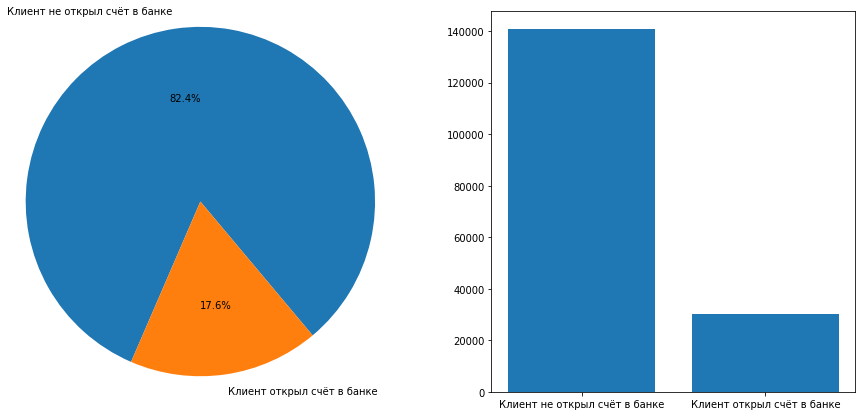

Распределение классов в тренировочном датасете:
0    0.823972
1    0.176028
Name: open_account_flg, dtype: float64


In [164]:
# Посмотрим на распределение целевого значения (проверка на дисбаланс классов)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (15,7))

#plots
ax[0].pie(train_df["open_account_flg"].value_counts(), \
          labels = ['Клиент не открыл счёт в банке', 'Клиент открыл счёт в банке'],
          radius= 1.2, autopct='%1.1f%%', startangle=-50)

ax[1].bar(['Клиент не открыл счёт в банке', 'Клиент открыл счёт в банке'], 
          train_df["open_account_flg"].value_counts().tolist())

plt.subplots_adjust(wspace=0.3)
plt.show()


#У нас имеется небольшой дисбаланас классов
print("Распределение классов в тренировочном датасете:\n",
      train_df["open_account_flg"].value_counts(normalize=True),
      sep='')

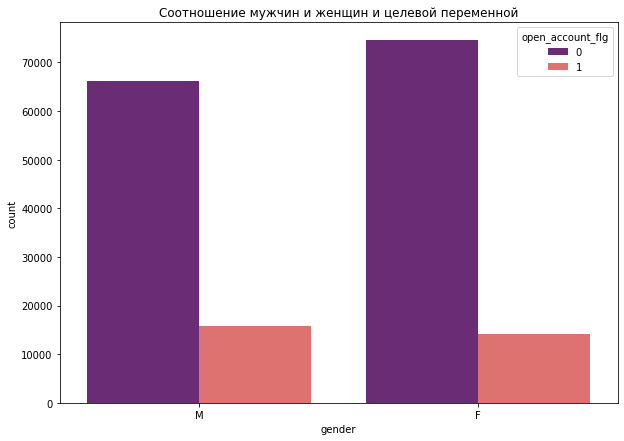

In [473]:
#Посмотрим на соотношение мужчин и женщин относительно целевой переменной
plt.figure(figsize=(10,7))
plt.title("Соотношение мужчин и женщин и целевой переменной")
sns.countplot(data=train_df, x="gender", hue="open_account_flg", palette='magma')
plt.show()

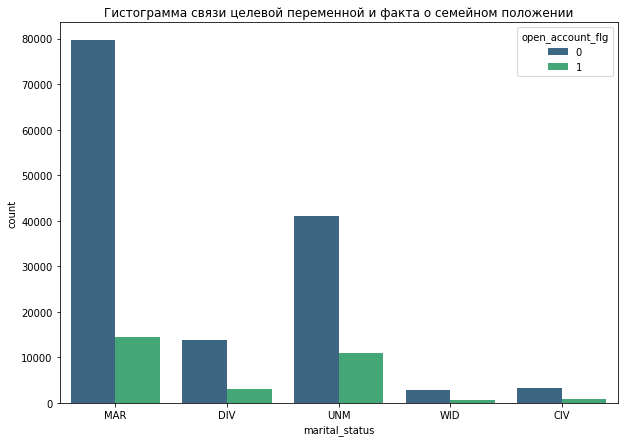

In [474]:
plt.figure(figsize=(10,7))
plt.title("Гистограмма связи целевой переменной и факта о семейном положении")
sns.countplot(data=train_df, x="marital_status", hue="open_account_flg", palette='viridis')
plt.show()

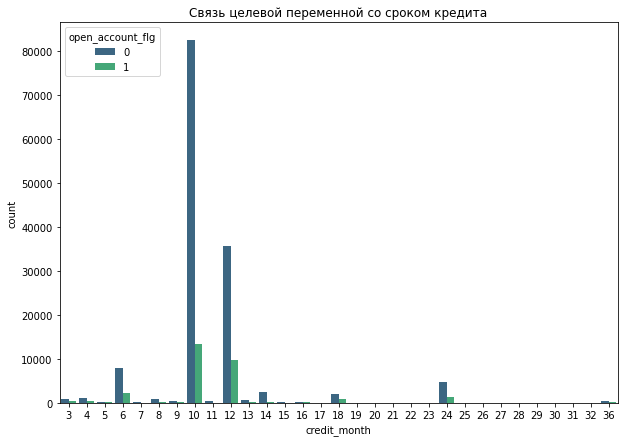

In [466]:
plt.figure(figsize=(10,7))
plt.title('Связь целевой переменной со сроком кредита')
sns.countplot(data=train_df, x="credit_month", hue="open_account_flg", palette='viridis')
plt.show()

# 2) Numerical Features

In [476]:
numerical = ["age", "credit_sum", "credit_month", "score_shk", "monthly_income", "credit_count"]
categorical = ['gender', 'marital_status', 'job_position', 'education', 'living_region']

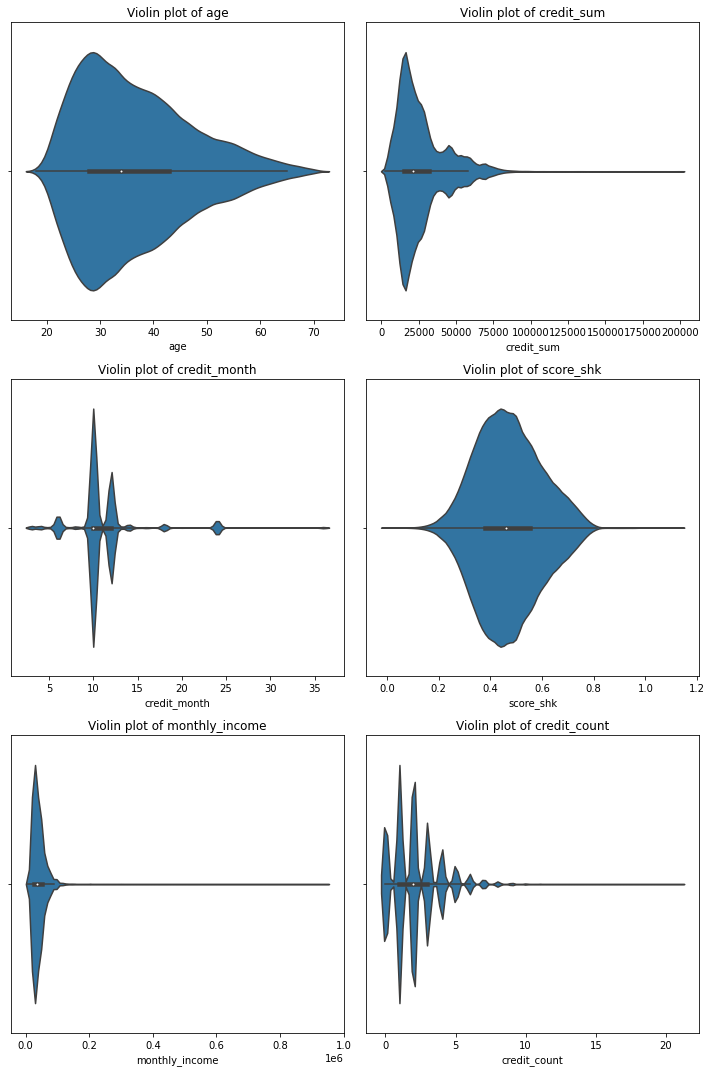

In [27]:
# Одномерный анализ

# Violin графики для каждой переменной
num_columns = len(train_df[numerical].columns)
num_rows = (num_columns + 1) // 2

plt.figure(figsize=(10, 5*num_rows))
for i, column in enumerate(train_df[numerical].columns):
    plt.subplot(num_rows, 2, i+1)
    sns.violinplot(x=train_df[numerical][column])
    plt.title(f'Violin plot of {column}')

plt.tight_layout()
plt.show()

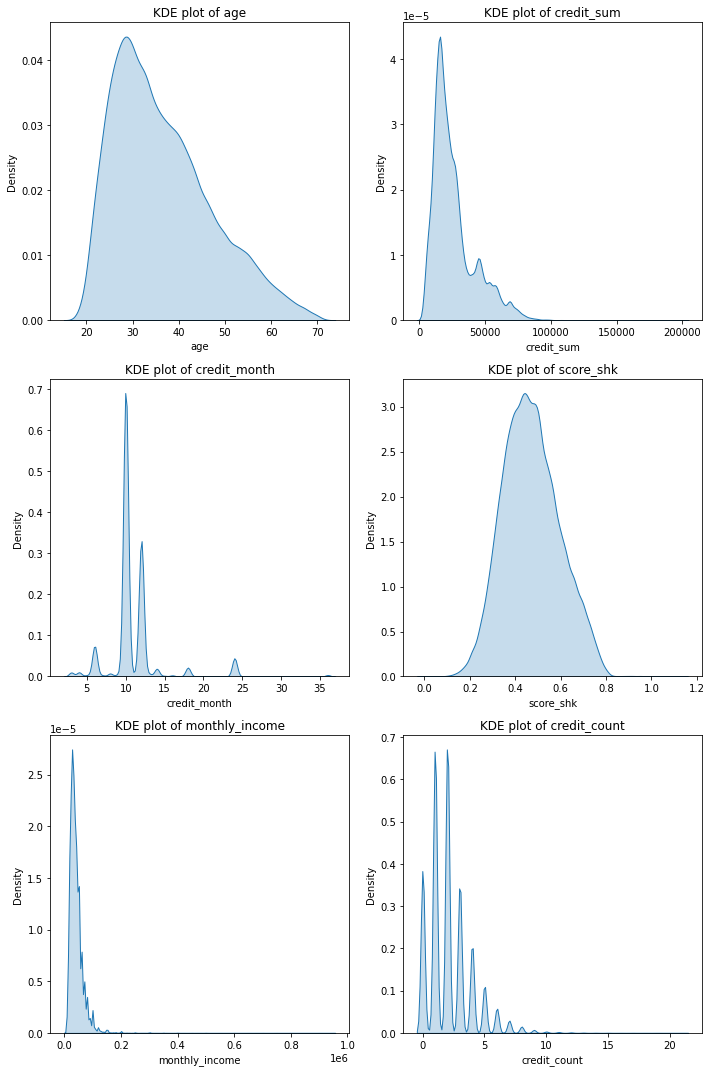

In [28]:
#Посмотрим на типы распределений наших количественных признаков
num_columns = len(train_df[numerical].columns)
num_rows = (num_columns + 1) // 2

plt.figure(figsize=(10, 5*num_rows))
for i, column in enumerate(train_df[numerical].columns):
    plt.subplot(num_rows, 2, i+1)
    sns.kdeplot(x=train_df[numerical][column], fill=True)
    plt.title(f'KDE plot of {column}')

plt.tight_layout()
plt.show()

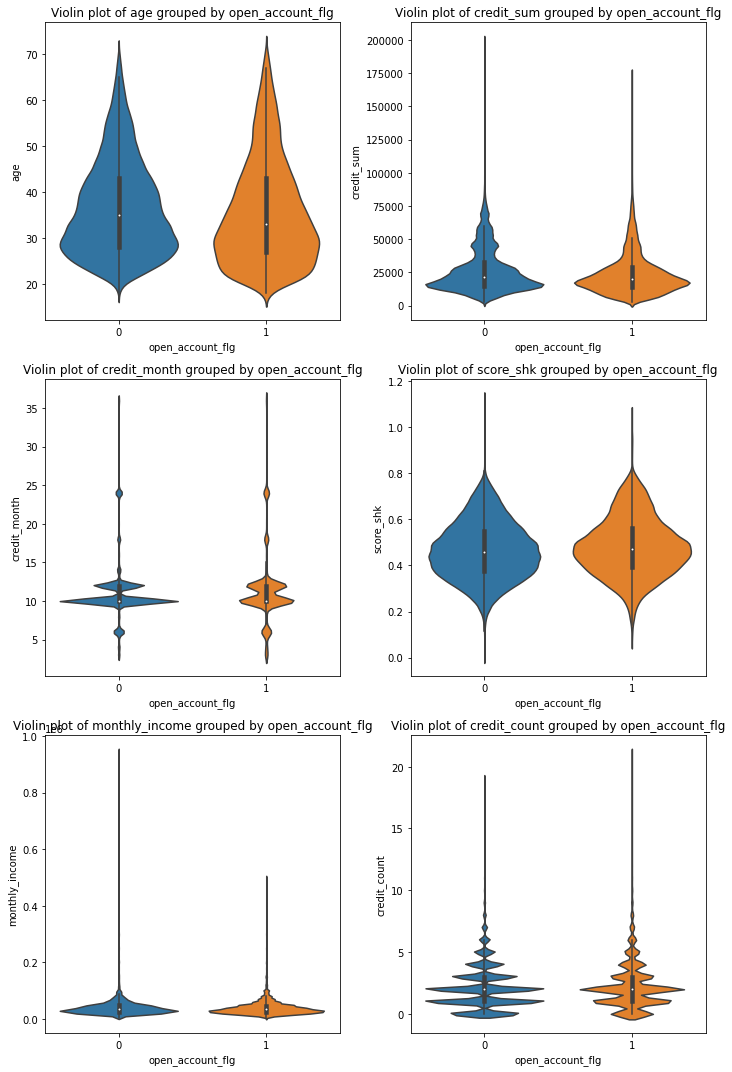

In [29]:
numerical.append('open_account_flg')
num_columns = len(train_df[numerical].columns.drop('open_account_flg'))
num_rows = (num_columns + 1) // 2

plt.figure(figsize=(10, 5*num_rows))
for i, column in enumerate(train_df[numerical].columns.drop('open_account_flg')):
    plt.subplot(num_rows, 2, i+1)
    sns.violinplot(data=train_df[numerical], x='open_account_flg', y=column)
    plt.title(f'Violin plot of {column} grouped by open_account_flg')

plt.tight_layout()
plt.show()

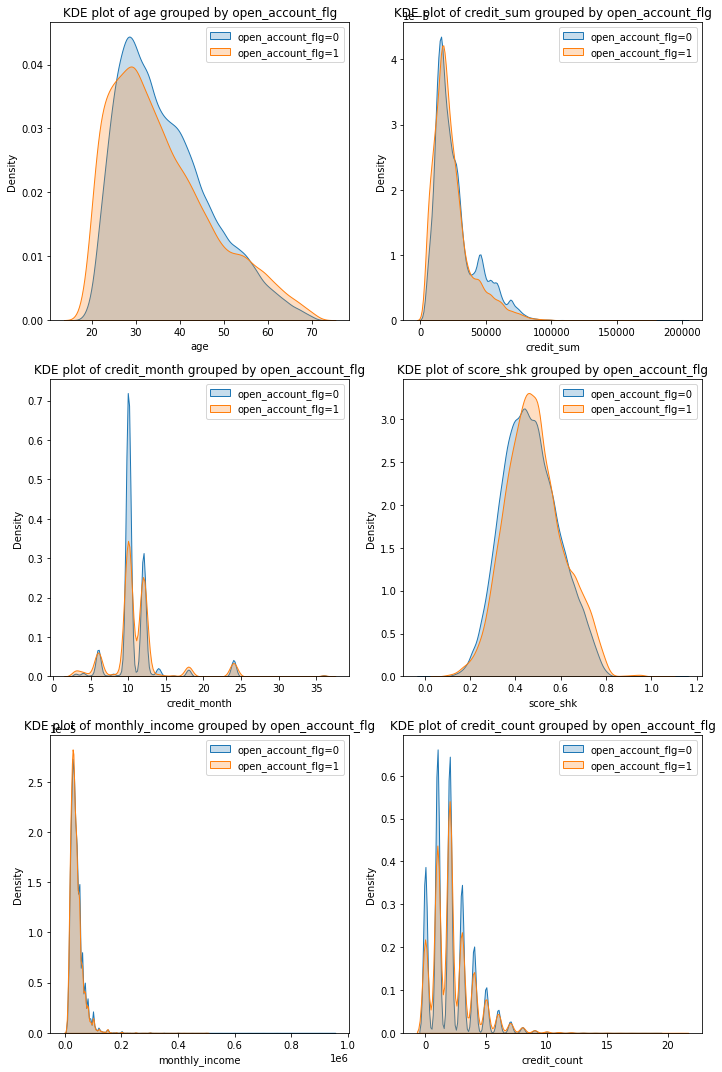

In [30]:
num_columns = len(train_df[numerical].columns.drop('open_account_flg'))
num_rows = (num_columns + 1) // 2

plt.figure(figsize=(10, 5*num_rows))
for i, column in enumerate(train_df[numerical].columns.drop('open_account_flg')):
    plt.subplot(num_rows, 2, i+1)
    sns.kdeplot(data=train_df[numerical].query('open_account_flg == 0')[column], \
                label='open_account_flg=0', fill=True)
    sns.kdeplot(data=train_df[numerical].query('open_account_flg == 1')[column], \
                label='open_account_flg=1', fill=True)
    plt.title(f'KDE plot of {column} grouped by open_account_flg')
    plt.legend()

plt.tight_layout()
plt.show()

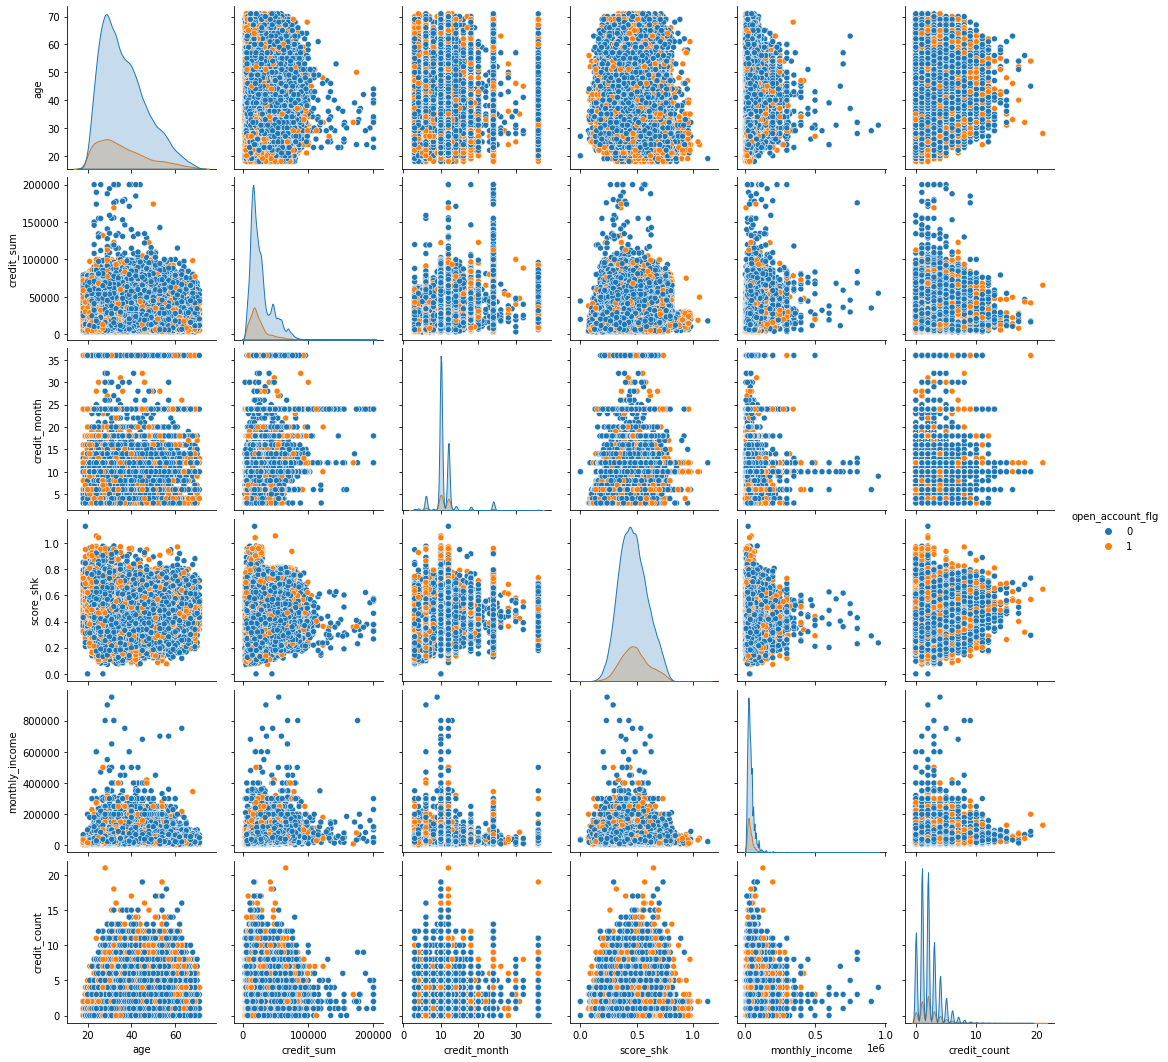

In [31]:
sns.pairplot(train_df[numerical], hue='open_account_flg')

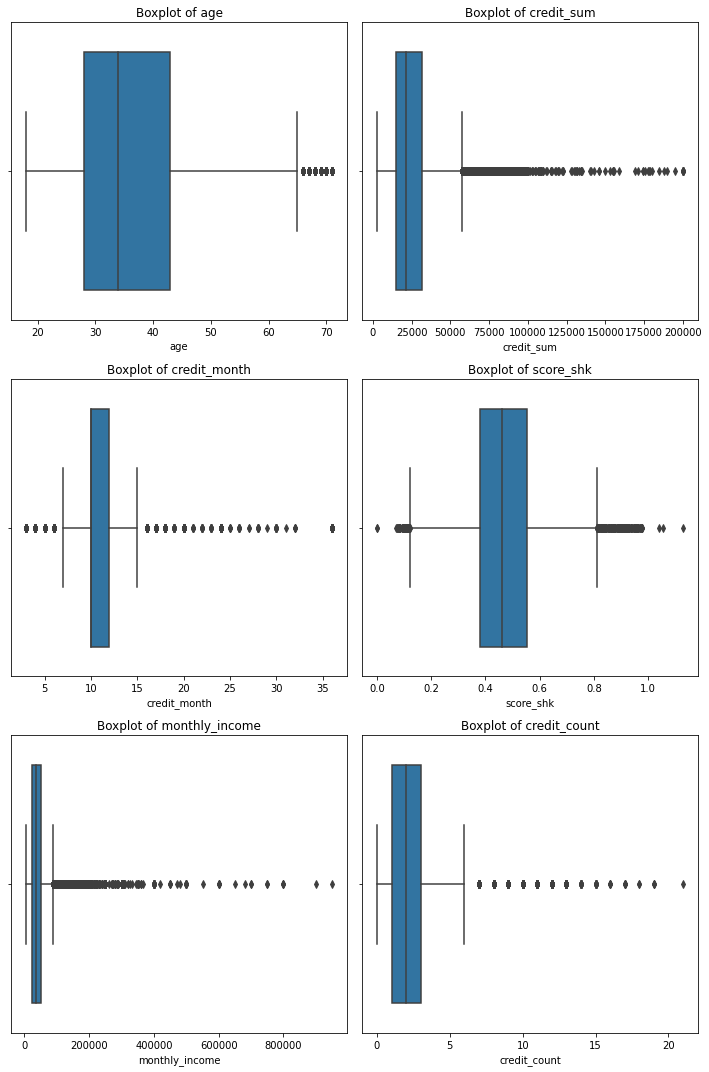

In [32]:
num_columns = len(train_df[numerical].columns.drop('open_account_flg'))
num_rows = (num_columns + 1) // 2

plt.figure(figsize=(10, 5*num_rows))
for i, column in enumerate(train_df[numerical].columns.drop('open_account_flg')):
    plt.subplot(num_rows, 2, i+1)
    sns.boxplot(data=train_df[numerical].drop('open_account_flg', axis=1), 
                x = train_df[numerical].drop('open_account_flg', axis=1)[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

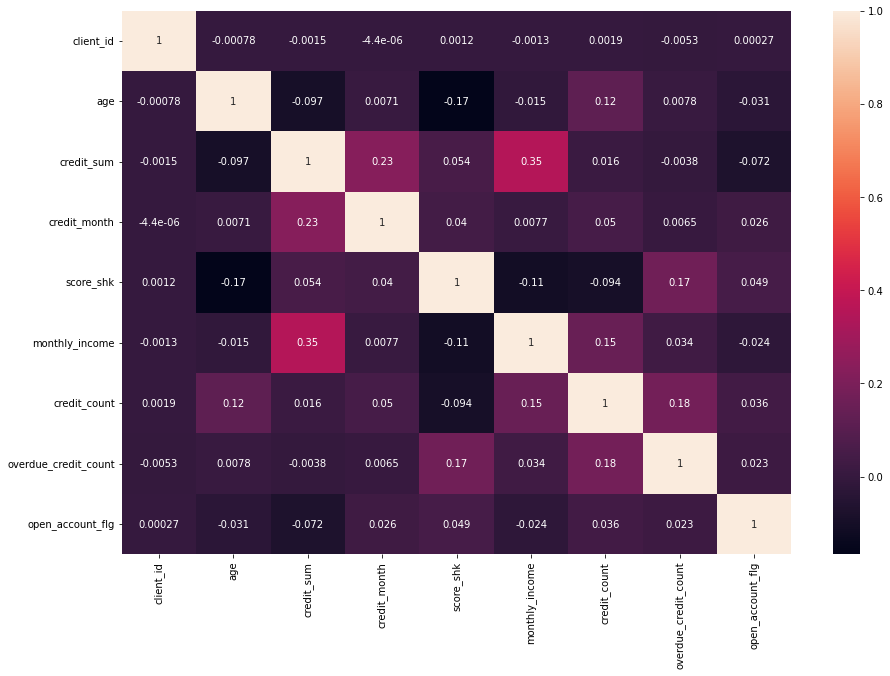

In [477]:
plt.figure(figsize=(15,10))
sns.heatmap(train_df.corr(), annot=True)
plt.show()

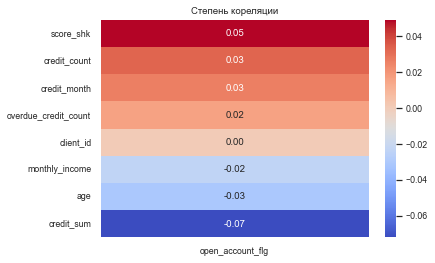

In [193]:
corr = train_df.corr()
target_corr = corr['open_account_flg'].drop('open_account_flg')

# Сортируем значения кореляции по убыванию 
target_corr_sorted = target_corr.sort_values(ascending=False)

#Создаем тепловую карту кореляции признаков с целевой переменной
sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Степень кореляции')
plt.show()

# Итоги EDA

1. В классах имеется дисбаланс
2. Между фичами нет значительной кореляции
3. Имеются выбросы

# Feature Engineering

In [478]:
#USER DEFINE FUNCTION 
def vibros_calculation(feature):
    '''Функция используется для удаления обнаружения и удаления выбрасов
    Она принимает на вход признак в виде Series и модицифирует данный признак и тем самым Датафрейм'''
    k = 1.5
    Q1 = feature.quantile(0.25) #первый квардиль(25% наблюдений ниже)
    Q2 = feature.quantile(0.5) #второй квардиль(медиана, 50% наблюдений ниже)
    Q3 = feature.quantile(0.75)#третий квардиль(медиана, 75% наблюдений ниже)

    IQR = Q3 - Q1 #межквартальный размах 
    Y1 = Q1 - k * IQR # нижняя граница
    Y2 = Q3 + k * IQR #верхняя граница
    
    global train_df
    train_df = train_df[(feature < Y2) & (feature > Y1)]
    
#Избавимся от выбросов в наших количественных признаков  
vibros_calculation(train_df["age"])
vibros_calculation(train_df["credit_sum"])
vibros_calculation(train_df["credit_month"])
vibros_calculation(train_df["score_shk"])
vibros_calculation(train_df["monthly_income"])
vibros_calculation(train_df["credit_count"])

Обработка пропусков

In [479]:
train_df = train_df[~train_df["living_region"].isna()]

train_df = train_df.fillna(
    {'credit_count': train_df['credit_count'].median(),
    'overdue_credit_count': train_df['overdue_credit_count'].median(),
    'monthly_income': train_df['monthly_income'].median()}
    )

train_df.isnull().sum()

client_id               0
gender                  0
age                     0
marital_status          0
job_position            0
credit_sum              0
credit_month            0
tariff_id               0
score_shk               0
education               0
living_region           0
monthly_income          0
credit_count            0
overdue_credit_count    0
open_account_flg        0
dtype: int64

In [480]:
#Преобразуем наши категориальные признаки
train_df["gender"].replace({'M':1, 'F':0}, inplace=True)
train_df["marital_status"].replace({'MAR':0, 'DIV':1, 'UNM':2, 'WID':3, 'CIV':4}, inplace=True)
train_df["education"].replace({'GRD':0, 'SCH':1, 'UGR':2, 'PGR':3, 'ACD':4}, inplace=True)

# разделим наши категориальные признаки на отдельные фичи
device_columns1 = pd.get_dummies(train_df["job_position"])
train_df = pd.concat([train_df,device_columns1], axis=1).drop(columns='job_position')

device_columns2 = pd.get_dummies(train_df["living_region"])
train_df = pd.concat([train_df, device_columns2], axis=1).drop(columns='living_region')

# Балансировка классов при помощи Oversampling

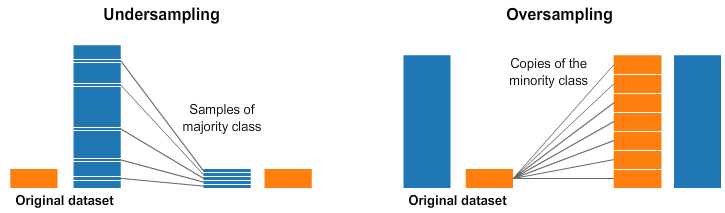

In [71]:
display.Image(r"C:\Users\murod\Downloads\1_7xf9e1EaoK5n05izIFBouA.png")

In [215]:
over = SMOTE()
f2 = train_df.drop(['client_id','open_account_flg', 'tariff_id'], axis=1).values
t2 = train_df["open_account_flg"].values
f2, t2 = over.fit_resample(f2, t2)
Counter(t2)

#разделим наши данные на сплиты
train_x, test_x, train_y, test_y = train_test_split(f2, t2, test_size=0.25, random_state=42)

# Modeling

In [380]:
model_catboost = CatBoostClassifier()

param_grid = {'learning_rate': [0.02, 0.05, 0.08,],
              'depth': [6, 8, 10],
              'l2_leaf_reg': [2, 3, 5],
              'random_strength':[1,2,3]}

grid = GridSearchCV(estimator=model_catboost, param_grid=param_grid, cv=7)
grid.fit(train_x, train_y)

print("Лучшие гиперпараметры для данной модели: ",grid.best_params_)

Лучшие гиперпараметры для данной модели:  {'learning_rate': 0.08, 'depth': 10, 'l2_leaf_reg': 5, 'random_strength': 3}


In [398]:
best_model = CatBoostClassifier(learning_rate = 0.08,  depth=10, l2_leaf_reg = 5, 
                                    bagging_temperature = 1, random_strength=3)
best_model.fit(train_x, train_y)

print(f'Точность модели на тренировочном сплите = {best_model.score(train_x, train_y)}')
print(f'Точность модели на тестовом сплите = {best_model.score(test_x, test_y)}')

Точность модели на тренировочных данных = 0.9241804497366735
Точность модели на тренировочных данных = 0.9074437506194866


Кросс валидация на тестовых данных

In [405]:
validation_scores = cross_val_score(best_model, test_x, test_y, cv=5)
validation_scores

array([0.90712657, 0.90078303, 0.90167509, 0.90435127, 0.9039548 ])

In [406]:
print(f'Средняя оценка на кроссвалидации = {np.mean(validation_scores)}')

Средняя оценка на кроссвалидации = 0.903578154425612


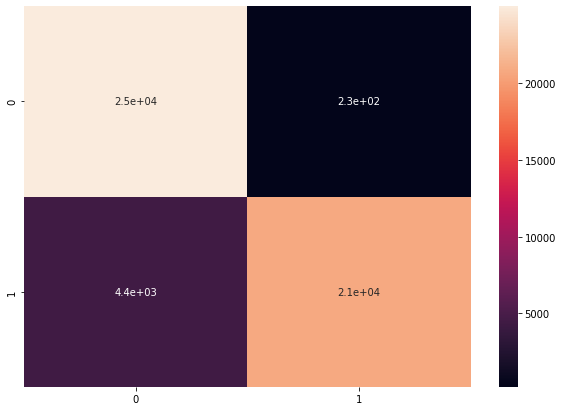

              precision    recall  f1-score   support

           0       0.85      0.99      0.91     25212
           1       0.99      0.82      0.90     25233

    accuracy                           0.91     50445
   macro avg       0.92      0.91      0.91     50445
weighted avg       0.92      0.91      0.91     50445



In [414]:
#Посмотрим на метрики качества нащей модели
prediction = best_model.predict(test_x)
matrix = confusion_matrix(test_y, prediction)

plt.figure(figsize=(10,7))
sns.heatmap(matrix, annot=True)
plt.show()

print(classification_report(test_y, prediction))

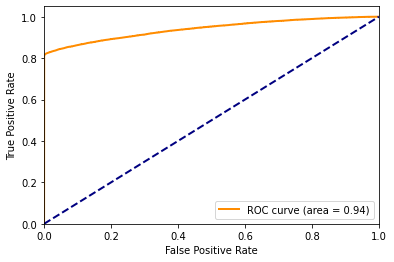

In [482]:
y_score = best_model.predict_proba(test_x)[:,1]

#Посмотрим также на площадь под ROC-кривой
fpr, tpr, _ = roc_curve(test_y, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Предсказание тестовых данных

In [443]:
test_modified = test_df.drop(['client_id', 'tariff_id'], axis=1)
test_modified["gender"].replace({'M':1, 'F':0}, inplace=True)
test_modified["marital_status"].replace({'MAR':0, 'DIV':1, 'UNM':2, 'WID':3, 'CIV':4}, inplace=True)
test_modified["education"].replace({'GRD':0, 'SCH':1, 'UGR':2, 'PGR':3, 'ACD':4}, inplace=True)
device_columns3 = pd.get_dummies(test_modified["job_position"])
test_modified = pd.concat([test_modified,device_columns3], axis=1).drop(columns='job_position')

device_columns4 = pd.get_dummies(test_modified["living_region"])
test_modified = pd.concat([test_modified, device_columns4], axis=1).drop(columns='living_region')

In [445]:
final_prediction = best_model.predict(test_modified)

In [446]:
final_prediction

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [455]:
final_prediction_df = pd.DataFrame(final_prediction).rename(columns={0:'prediction'})
final_prediction_df

,prediction
0,0
1,0
2,0
3,0
4,0
...,...
91935,0
91936,0
91937,0
91938,0


In [458]:
#Добавим предсказания модели к тестовому датафрейму
pd.concat([test_df, final_prediction_df], axis=1 )

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,prediction
0,170747,F,48,MAR,UMN,16558.00,10,2023-01-01 00:00:00,0.370409,GRD,ХАКАСИЯ РЕСП,34000,2.0,0.0,0
1,170748,M,29,MAR,SPC,7028.72,6,2023-04-01 00:00:00,0.377281,SCH,ОБЛ КЕМЕРОВСКАЯ,19000,3.0,0.0,0
2,170749,F,20,UNM,SPC,13019.00,10,2023-06-01 00:00:00,0.538515,SCH,ОБЛ БЕЛГОРОДСКАЯ,25000,1.0,0.0,0
3,170750,F,41,MAR,SPC,9379.00,10,2023-01-01 00:00:00,0.482520,GRD,ОБЛ ИРКУТСКАЯ,30000,0.0,0.0,0
4,170751,F,31,MAR,SPC,13990.00,6,1943-01-01 00:00:00,0.485914,GRD,ОБЛ КИРОВСКАЯ,20000,2.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91935,262682,M,41,MAR,SPC,10114.00,12,2023-09-01 00:00:00,0.347262,SCH,САНКТ-ПЕТЕРБУРГ,30000,1.0,0.0,0
91936,262683,M,33,UNM,SPC,14807.00,6,2023-06-01 00:00:00,0.404430,SCH,ОБЛ БРЯНСКАЯ,30000,0.0,0.0,0
91937,262684,F,25,MAR,SPC,19718.00,10,2023-04-01 00:00:00,0.341982,GRD,ПСКОВСКАЯ ОБЛ,20000,1.0,0.0,0
91938,262685,M,26,UNM,SPC,22258.00,10,1943-01-01 00:00:00,0.698764,SCH,ОБЛ ВОЛГОГРАДСКАЯ,28000,NaN,NaN,0
